In [1]:
import yaml

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker, scoped_session
import pandas as pd

import mplfinance as mpf

In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
DATABASE_URI = f'''postgresql+psycopg2://{config['db']['user']}:{config['db']['password']}@{config['db']['host']}:{config['db']['port']}/{config['db']['database']}'''
engine = create_engine(DATABASE_URI)
Session = scoped_session(sessionmaker(bind=engine))

interval_period = {
    '30m': '30 minutes',
    '1h': '1 hour',
    '2h': '2 hours',
    '4h': '4 hours',
    '6h': '6 hours',
    '12h': '12 hours',
    '1d': '1 day',
    '1w': '1 week',
}

In [4]:
def get_data(symbol, interval, amount):
    # 开启一个新的会话(session)
    with Session() as session:
        # SQL查询
        query = f'''
                SELECT
                    time_bucket ( '{interval}', time ) AS period,
        	        FIRST ( open, time ) AS open,
        	        MAX ( high ) AS high,
        	        MIN ( low ) AS low,
        	        LAST ( close, time ) AS close,
        	        SUM ( volume ) AS volume 
                FROM
        	        "{symbol}"
                GROUP BY period
                ORDER BY period DESC
                LIMIT {amount};
            '''

        # 使用pandas的read_sql_query函数直接将SQL查询结果转换为DataFrame
        df = pd.read_sql_query(query, session.bind)

        # 将period列转换为pandas datetime对象
        df['period'] = pd.to_datetime(df['period'])

        # 因为我们按照时间降序排序获取了数据，所以可能需要将其重新排序以保持时间升序
        df.sort_values('period', inplace=True)
        df.reset_index(drop=True, inplace=True)

        # 将当前的整数索引保存为一个新的列
        df['index'] = df.index

        # 将period列设为索引
        df.set_index('period', inplace=True)

        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'index']

        return df


In [5]:
def add_bollinger_bands(df):
    # 计算中轨，这里使用20日移动平均线
    df['Middle Band'] = df['Close'].rolling(window=20).mean()
    # 计算标准差
    df['Standard Deviation'] = df['Close'].rolling(window=20).std()
    # 计算上轨和下轨
    df['Upper Band'] = df['Middle Band'] + 2 * df['Standard Deviation']
    df['Lower Band'] = df['Middle Band'] - 2 * df['Standard Deviation']
    return df

In [6]:
def merge_candle(df):
    drop_rows = []
    i = 0
    while i < df.shape[0] - 1:
        j = i + 1
        curr_row = df.iloc[i]
        next_row = df.iloc[j]
        while i > 0 and ((curr_row['High'] >= next_row['High'] and curr_row['Low'] <= next_row['Low']) or (
                curr_row['High'] <= next_row['High'] and curr_row['Low'] >= next_row['Low'])):
            if curr_row['High'] >= df.iloc[i - 1]['High']:
                df.loc[df.index[i], 'High'] = max(curr_row['High'], next_row['High'])
                df.loc[df.index[i], 'Low'] = max(curr_row['Low'], next_row['Low'])
                df.loc[df.index[i], 'Open'] = df.loc[df.index[i], 'Low']
                df.loc[df.index[i], 'Close'] = df.loc[df.index[i], 'High']
                df.loc[df.index[i], 'Volume'] = curr_row['Volume'] + next_row['Volume']
            else:
                df.loc[df.index[i], 'High'] = min(curr_row['High'], next_row['High'])
                df.loc[df.index[i], 'Low'] = min(curr_row['Low'], next_row['Low'])
                df.loc[df.index[i], 'Open'] = df.loc[df.index[i], 'High']
                df.loc[df.index[i], 'Close'] = df.loc[df.index[i], 'Low']
                df.loc[df.index[i], 'Volume'] = curr_row['Volume'] + next_row['Volume']
            drop_rows.append(df.index[j])
            if j < df.shape[0] - 1:
                j += 1
                curr_row = df.iloc[i]
                next_row = df.iloc[j]
            else:
                break
        i = j
    df = df.drop(drop_rows)
    return df

In [7]:
def identify_fractal(df):
    """
    识别顶分型和底分型
    """

    # 创建一个新的列来存储分型
    df['fractal'] = None

    # 识别顶分型
    df.loc[(df['High'].shift(1) < df['High']) &
           (df['High'].shift(-1) < df['High']), 'fractal'] = 'top'

    # 识别底分型
    df.loc[(df['Low'].shift(1) > df['Low']) &
           (df['Low'].shift(-1) > df['Low']), 'fractal'] = 'bottom'

    return df

In [8]:
def filter_fractals(df):
    # 设置一个标记来跟踪最后一个有效的分型是顶分型还是底分型
    last_valid_fractal = None
    last_valid_fractal_index = None
    # 再设置一个标记来跟踪倒数第二个有效的分型是顶分型还是底分型
    pre_last_valid_fractal = None
    pre_last_valid_fractal_index = None

    # 找出所有的分型
    fractals = df.loc[df['fractal'].notnull()].copy()

    # 创建shift列
    fractals['next_row'] = df.index.to_series().shift(-1)
    fractals['prev_row'] = df.index.to_series().shift(1)

    for index, row in fractals.iterrows():
        # 如果还没有找到任何有效的分型，那么当前的分型就是有效的
        if last_valid_fractal is None:
            last_valid_fractal = row
            last_valid_fractal_index = index
        else:
            # 检查当前分型是否满足有效性规则
            if row['fractal'] == last_valid_fractal['fractal']:
                # 新的顶分型的高点比之前有效的顶分型的高点还要高
                if row['fractal'] == 'top':
                    if row['High'] > last_valid_fractal['High']:
                        df.loc[last_valid_fractal_index, 'fractal'] = None
                        last_valid_fractal = row
                        last_valid_fractal_index = index
                    else:
                        df.loc[index, 'fractal'] = None
                # 新的底分型的低点比之前有效底分型的低点还要低
                if row['fractal'] == 'bottom':
                    if row['Low'] < last_valid_fractal['Low']:
                        df.loc[last_valid_fractal_index, 'fractal'] = None
                        last_valid_fractal = row
                        last_valid_fractal_index = index
                    else:
                        df.loc[index, 'fractal'] = None
            # 顶分型的最高点必须高于前一个底分型的最高点
            # 底分型的低点必须低于前一个顶分型的低点
            elif ((row['fractal'] == 'top' and row['High'] >
                   df.loc[last_valid_fractal['prev_row']:last_valid_fractal['next_row'], 'High'].max()) or
                  (row['fractal'] == 'bottom' and row['Low'] <
                   df.loc[last_valid_fractal['prev_row']:last_valid_fractal['next_row'], 'Low'].min())):
                # 两个有效分型之间必须有至少一根K线
                if df.loc[row['prev_row'], 'index'] - df.loc[last_valid_fractal['next_row'], 'index'] > 1:
                    pre_last_valid_fractal = last_valid_fractal
                    pre_last_valid_fractal_index = last_valid_fractal_index
                    last_valid_fractal = row
                    last_valid_fractal_index = index
                else:
                    if pre_last_valid_fractal is not None:
                        if row['fractal'] == 'top':
                            if row['High'] > pre_last_valid_fractal['High']:
                                df.loc[pre_last_valid_fractal_index, 'fractal'] = None
                                df.loc[last_valid_fractal_index, 'fractal'] = None
                                last_valid_fractal = row
                                last_valid_fractal_index = index
                                pre_last_valid_fractal = None
                                pre_last_valid_fractal_index = None
                            else:
                                df.loc[index, 'fractal'] = None
                        if row['fractal'] == 'bottom':
                            if row['Low'] < pre_last_valid_fractal['Low']:
                                df.loc[pre_last_valid_fractal_index, 'fractal'] = None
                                df.loc[last_valid_fractal_index, 'fractal'] = None
                                last_valid_fractal = row
                                last_valid_fractal_index = index
                                pre_last_valid_fractal = None
                                pre_last_valid_fractal_index = None
                            else:
                                df.loc[index, 'fractal'] = None
                    else:
                        df.loc[index, 'fractal'] = None
            else:
                df.loc[index, 'fractal'] = None

    return df

In [9]:
def find_centers(df):
    # 上一个中枢的顶和底
    last_center = (0, 0)

    # 在df中创建新的center列
    df['center'] = None

    # 过滤出有分型标记的数据
    df_fractal = df.dropna(subset=['fractal'])

    # 遍历有分型标记的数据
    for i in range(df_fractal.shape[0] - 3):
        if df_fractal['fractal'].iloc[i] == 'top':
            if last_center[0] < df_fractal['High'].iloc[i] < last_center[1] \
                    or last_center[0] < df_fractal['Low'].iloc[i + 1] < last_center[1]\
                    or last_center[0] < df_fractal['High'].iloc[i + 2] < last_center[1]\
                    or last_center[0] < df_fractal['Low'].iloc[i + 3] < last_center[1]:
                continue
            # 中枢的顶是两个顶分型中最低的价格，中枢的底是两个底分型中最高的价格
            center_high = min(df_fractal['High'].iloc[i], df_fractal['High'].iloc[i + 2])
            center_low = max(df_fractal['Low'].iloc[i + 1], df_fractal['Low'].iloc[i + 3])
            # 如果中枢的高点价格高于低点价格，那么中枢成立
            if center_low < center_high:
                if df_fractal['High'].iloc[i] == center_high:
                    df.loc[df_fractal.index[i], 'center'] = 'start'
                    if df_fractal['Low'].iloc[i + 1] == center_low:
                        df.loc[df_fractal.index[[i + 1]], 'center'] = 'stop'
                    else:
                        df.loc[df_fractal.index[[i + 3]], 'center'] = 'stop'
                else:
                    df.loc[df_fractal.index[[i + 1]], 'center'] = 'start'
                    df.loc[df_fractal.index[[i + 2]], 'center'] = 'stop'
                last_center = (center_low, center_high)
        if df_fractal['fractal'].iloc[i] == 'bottom':
            if last_center[0] < df_fractal['Low'].iloc[i] < last_center[1] \
                    or last_center[0] < df_fractal['High'].iloc[i + 1] < last_center[1]\
                    or last_center[0] < df_fractal['Low'].iloc[i + 2] < last_center[1]\
                    or last_center[0] < df_fractal['High'].iloc[i + 3] < last_center[1]:
                continue
            # 中枢的顶是两个顶分型中最低的价格，中枢的底是两个底分型中最高的价格
            center_high = min(df_fractal['High'].iloc[i + 1], df_fractal['High'].iloc[i + 3])
            center_low = max(df_fractal['Low'].iloc[i], df_fractal['Low'].iloc[i + 2])
            # 如果中枢的高点价格高于低点价格，那么中枢成立
            if center_low < center_high:
                if df_fractal['Low'].iloc[i] == center_low:
                    df.loc[df_fractal.index[[i]], 'center'] = 'start'
                    if df_fractal['High'].iloc[i + 1] == center_high:
                        df.loc[df_fractal.index[[i + 1]], 'center'] = 'stop'
                    else:
                        df.loc[df_fractal.index[[i + 3]], 'center'] = 'stop'
                else:
                    df.loc[df_fractal.index[[i + 1]], 'center'] = 'start'
                    df.loc[df_fractal.index[[i + 2]], 'center'] = 'stop'
                last_center = (center_low, center_high)

    return df

In [10]:
symbol = 'BCHUSDT'
interval = '30m'
amount = 200
df = get_data(symbol, interval_period[interval], amount)
df = df[:-1]
df = add_bollinger_bands(df)
df_merged = merge_candle(df)
df_fractaled = identify_fractal(df_merged)
df_filtered = filter_fractals(df_fractaled)
df_centered = find_centers(df_filtered)

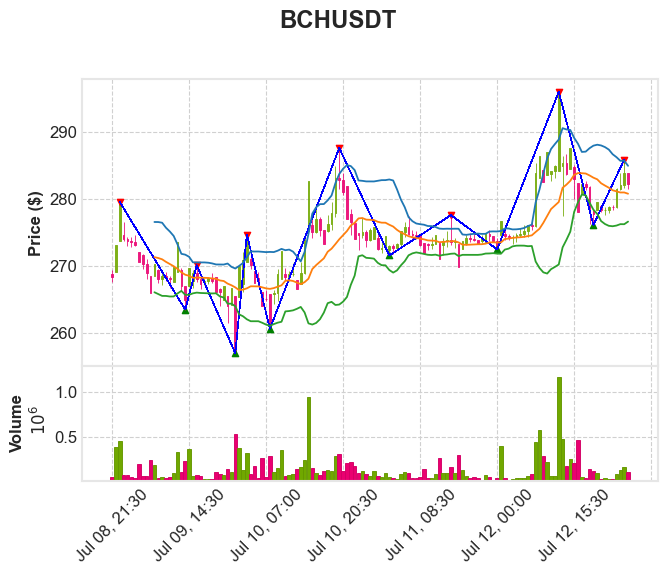

In [11]:
# 创建一个addplot对象，用于在主图上添加布林带
addplot_boll = [mpf.make_addplot(df_centered['Upper Band']),  # 添加上轨
      mpf.make_addplot(df_centered['Middle Band']),  # 添加中轨
      mpf.make_addplot(df_centered['Lower Band'])]  # 添加下轨

# 创建两个布尔数组，用于标记顶分型和底分型
tops = (df_centered['fractal'] == 'top')
bottoms = (df_centered['fractal'] == 'bottom')

# 创建两个新的Series，长度与df_identified相同
tops_series = pd.Series(index=df_centered.index)
bottoms_series = pd.Series(index=df_centered.index)

# 对于顶分型和底分型，将价格填入相应的Series
tops_series[tops] = df_centered['High'][tops]
bottoms_series[bottoms] = df_centered['Low'][bottoms]

# 使用make_addplot()来创建额外的绘图，用于标记顶分型和底分型
addplot_tops = mpf.make_addplot(tops_series, scatter=True, markersize=20, marker='v', color='r')
addplot_bottoms = mpf.make_addplot(bottoms_series, scatter=True, markersize=20, marker='^', color='g')

# 创建一个新的DataFrame，只包含有分型的行
df_fractals = df_centered.dropna(subset=['fractal'])

# 初始化一个空列表用于存储分型和对应的价格
fractals_lines = []

# 在df_centered中遍历所有有分型的数据
for idx, row in df_fractals.iterrows():
    # 根据分型类型选择价格
    price = row['High'] if row['fractal'] == 'top' else row['Low']

    # 将日期和价格组成一个元组，并添加到列表中
    fractals_lines.append((idx, price))

addplot_all = addplot_boll + [addplot_tops, addplot_bottoms]
# 创建一个k线图，并将标记添加到图表中
mpf.plot(df_centered, type='candle', style='binance', title=symbol, ylabel='Price ($)', volume=True, ylabel_lower='Volume', volume_panel=1, addplot=addplot_all, alines=dict(alines=fractals_lines, colors='b', linewidths=0.5))

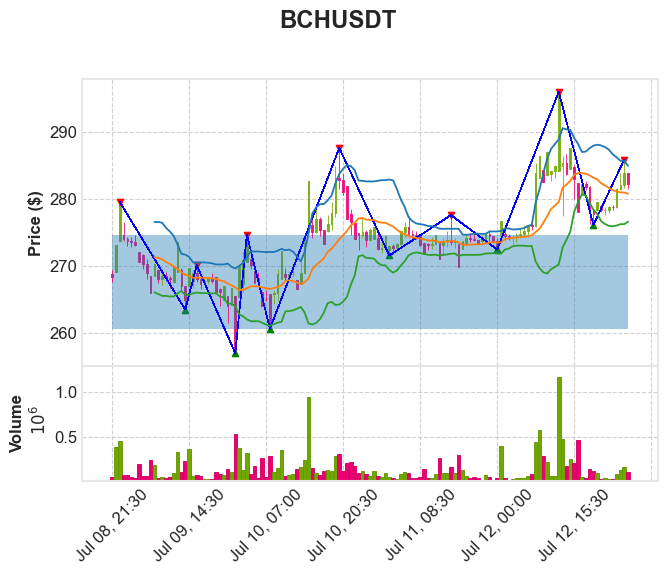

In [12]:
# 过滤出'center'列不为空的行
df_centered_notna = df_centered.dropna(subset=['center'])

# 初始化一个空的矩形列表
# rectangle = {}
rectangles = []

# 遍历df_centered_notna中的所有行，找到所有的中枢
for index, row in df_centered_notna.iterrows():
    if row['center'] == 'start':
        if row['fractal'] == 'top':
            # rectangle['y1'] = row['High']
            y1 = row['High']
        else:
            # rectangle['y1'] = row['Low']
            y1 = row['Low']
    elif row['center'] == 'stop':
        if row['fractal'] == 'top':
            # rectangle['y2'] = row['High']
            rectangle = dict(y1=y1, y2=row['High'], alpha=0.4)
        else:
            # rectangle['y2'] = row['Low']
            rectangle = dict(y1=y1, y2=row['Low'], alpha=0.4)
        rectangles.append(rectangle)

# 绘制K线图和中枢
mpf.plot(df_centered, type='candle', style='binance', title=symbol, ylabel='Price ($)', volume=True, ylabel_lower='Volume', volume_panel=1, addplot=addplot_all, alines=dict(alines=fractals_lines, colors='b', linewidths=0.5), fill_between=rectangles)
